<font size="+2" color="blue"><b>Natural Language Processing is Fun!</b></font><br><a id="1"></a>

Hi, welcome to my kernel. I just want to share this fun NLP notebook to you. I believe you can do better than me, 加油！

> I'm still new to data science, so don't trust me right away, but do an experiment first.

In [ ]:
!pip install emoji seaborn tensorflow wordcloud pillow -q

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

plt.rcParams['figure.figsize'] = [14, 8]

pd.set_option('display.max_colwidth', -1)

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sampleSubmission.csv')

train_df.drop('review_id', axis=1, inplace=True)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (146811, 2)
Test shape: (60427, 2)


# Are emoji's important?

![emoji](https://miro.medium.com/max/4000/0*a_PRfzH2Qrjn3Pnj.png)

In today’s online communication, **emoji** becoming the primary language that allows us to **communicate with anyone globally** when you need to be quick and precise. **Emoji** also playing an essential part in **sentiment analysis**, so **removing them might not be a right solution**.

If a company wants to find out how people are feeling about their product, they can capture people’s emotions by analyzing emojis. This will provide an essential piece of information, and it is vital for companies to understand their customer’s feelings better.

In [ ]:
import emoji  # https://pypi.org/project/emoji/

have_emoji_train_idx = []
have_emoji_test_idx = []

for idx, review in enumerate(train_df['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        have_emoji_train_idx.append(idx)
        
for idx, review in enumerate(test_df['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        have_emoji_test_idx.append(idx)

In [ ]:
train_emoji_percentage = round(len(have_emoji_train_idx) / train_df.shape[0] * 100, 2)
print(f'Train data has {len(have_emoji_train_idx)} rows that used emoji, that means {train_emoji_percentage} percent of the total')

test_emoji_percentage = round(len(have_emoji_test_idx) / test_df.shape[0] * 100, 2)
print(f'Test data has {len(have_emoji_test_idx)} rows that used emoji, that means {test_emoji_percentage} percent of the total')

Train data has 20048 rows that used emoji, that means 13.66 percent of the total
Test data has 7582 rows that used emoji, that means 12.55 percent of the total


## Emoji Cleaning pipeline

1. Change emoji to text
1. Delete repeated emoji
1. Change _ and - with whitespace

> For better understanding about this pipeline, i suggest you to try by yourself

In [ ]:
print('Without demojize: ', train_df.loc[70266, 'review'])
print('\nUsing demojize: ', emoji.demojize(train_df.loc[70266, 'review']))

Without demojize:  Excellent, Satisfied, Good Packaging, Recommended & Nice... 😊😊😊😊 😎😎😎😎

Using demojize:  Excellent, Satisfied, Good Packaging, Recommended & Nice... :smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes: :smiling_face_with_sunglasses::smiling_face_with_sunglasses::smiling_face_with_sunglasses::smiling_face_with_sunglasses:


In [ ]:
def emoji_cleaning(text):
    
    # Change emoji to text
    text = emoji.demojize(text).replace(":", " ")
    
    # Delete repeated emoji
    tokenizer = text.split()
    repeated_list = []
    
    for word in tokenizer:
        if word not in repeated_list:
            repeated_list.append(word)
    
    text = ' '.join(text for text in repeated_list)
    text = text.replace("_", " ").replace("-", " ")
    return text

In [ ]:
train_df_original = train_df.copy()
test_df_original = test_df.copy()

# emoji_cleaning
train_df.loc[have_emoji_train_idx, 'review'] = train_df.loc[have_emoji_train_idx, 'review'].apply(emoji_cleaning)
test_df.loc[have_emoji_test_idx, 'review'] = test_df.loc[have_emoji_test_idx, 'review'].apply(emoji_cleaning)

In [ ]:
# before cleaning
train_df_original.loc[have_emoji_train_idx, 'review'].tail()

146782    Mantul ... 😍😍👍👍👍 Cpt bgt sent nya.harganya's also fitting dikntong☺ Mksh yes may always be a success ...                                                                              
146787    Her material is different is different, but good overall. Seams are neat, using that is also good on the body. Create a price that much, okay really does. Pesen nyesel Gak deh here 👍
146800    Hehe thanks Baguuuuuuuuuuuus kaaaa😍😍😍😍😍😍😍😍👍👍👍👍👍👍👍👍👍👍👍                                                                                                                                 
146801    Explore huge crowd here Children seem to like the track lay 🤣🤣🤣.                                                                                                                      
146808     Awesome awesome quality merchandise value CP Very nice! 👍                                                                                                                            
Name: review, dtype: object

In [ ]:
# after cleaning
train_df.loc[have_emoji_train_idx, 'review'].tail()

146782    Mantul ... smiling face with heart eyes thumbs up Cpt bgt sent nya.harganya's also fitting dikntong smiling face Mksh yes may always be a success                             
146787    Her material is different different, but good overall. Seams are neat, using that also on the body. Create a price much, okay really does. Pesen nyesel Gak deh here thumbs up
146800    Hehe thanks Baguuuuuuuuuuuus kaaaa smiling face with heart eyes thumbs up                                                                                                     
146801    Explore huge crowd here Children seem to like the track lay rolling on the floor laughing .                                                                                   
146808    Awesome awesome quality merchandise value CP Very nice! thumbs up                                                                                                             
Name: review, dtype: object

# Text cleaning

Text cleaning is an important step for natural language processing tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

### In the dataset, i found a lot of:
* emoticon
* repeated word characters (especially in bahasa)
* punctuation
* shortened words 
* noisy text

> Let's try to clean them one by one

In [ ]:
def review_cleaning(text):
    
    # delete lowercase and newline
    text = text.lower()
    text = re.sub(r'\n', '', text)
    
    # change emoticon to text
    text = re.sub(r':\(', 'dislike', text)
    text = re.sub(r': \(\(', 'dislike', text)
    text = re.sub(r':, \(', 'dislike', text)
    text = re.sub(r':\)', 'smile', text)
    text = re.sub(r';\)', 'smile', text)
    text = re.sub(r':\)\)\)', 'smile', text)
    text = re.sub(r':\)\)\)\)\)\)', 'smile', text)
    text = re.sub(r'=\)\)\)\)', 'smile', text)
    
    # delete punctuation
    text = re.sub('[^a-z0-9 ]', ' ', text)
    
    tokenizer = text.split()
    
    return ' '.join([text for text in tokenizer])

In [ ]:
train_df['review'] = train_df['review'].apply(review_cleaning)
test_df['review'] = test_df['review'].apply(review_cleaning)

## Which rows have repeated words?

In [ ]:
repeated_rows_train = []
repeated_rows_test = []

for idx, review in enumerate(train_df['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_train.append(idx)
        
for idx, review in enumerate(test_df['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_test.append(idx)

In [ ]:
print(f'Total {len(repeated_rows_train)} rows')

Total 43139 rows


## Delete repeated words characters (problem)

* I usually use regex code below to delete repeated characters in bahasa indonesia
* But many english words have a repeated characters, example: good, less, will etc, it will damage these words
* You can look example below..

In [ ]:
test1 = "UUUURRGGGEENNTTT"
print(re.sub(r'(\w)\1+', r'\1', test1))

test2 = "good product quality good value for money "
print(re.sub(r'(\w)\1+', r'\1', test2))

URGENT
god product quality god value for money 


## Solution

* Repeated character in bahasa indonesia **usually repeated more than 2**, example: bagussssssssssssssssssss, tipisssss
* The solution is: **just preprocess more than 2 repeated character**, this way will not damage some english words

> Notes: some of repeated character only repeated twice, so this is NOT PERFECT way

In [ ]:
test3 = "bagussssssssssssssssssss bagusssssssssssssssssss real pict"
print(re.sub(r'(\w)\1{2,}', r'\1', test3))

bagus bagus real pict


In [ ]:
def delete_repeated_char(text):
    
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    
    return text

In [ ]:
train_df.loc[repeated_rows_train, 'review'] = train_df.loc[repeated_rows_train, 'review'].apply(delete_repeated_char)
test_df.loc[repeated_rows_test, 'review'] = test_df.loc[repeated_rows_test, 'review'].apply(delete_repeated_char)

In [ ]:
print('Before: ', train_df_original.loc[92129, 'review'])
print('After: ', train_df.loc[92129, 'review'])

print('\nBefore: ', train_df_original.loc[56938, 'review'])
print('After: ', train_df.loc[56938, 'review'])

print('\nBefore: ', train_df_original.loc[72677, 'review'])
print('After: ', train_df.loc[72677, 'review'])

print('\nBefore: ', train_df_original.loc[36558, 'review'])
print('After: ', train_df.loc[36558, 'review'])

Before:  Ttttthhhhhhhhheeeeeeee bbbbbbbeeeeesssttttttttt bbbbaaannngggettttttt
After:  the best banget

Before:  Mmmmmuuuuuuuuuurrrrrrraaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh mmmeeeeerrrrrriiiiiiiiiiiiiaaaaahhhhhhhhh👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍 = ¢ ✓ € ✓ € ¢} = {¢ × `{{|}} {¢ ¢ ¢ = ¢ = {÷ € € € = {{ €€ {{
After:  murah meriah thumbs up

Before:  Bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss soft tebel bangettt its materials also makasihhh shopeeeeeeeeeeee shopeeeeeeeeeeee shopeeeeeeeeeeee shopeeeeeeeeeeee the best seller friendly
After:  bagus bagus bagus bagus bagus bagus bagus bagus soft tebel banget its materials also makasih shope shope shope shope the best seller friendly

Before:  Ssuuukkkkaaa very
After:  ssuka very


## Delete the row that has noisy text

* Some of text are noisy, it will useless for training
* But some of text is not noisy, it just repeated
* If you understand many languages (just use google translate), you can choose which one are **noisy** or **just repeated**?

In [ ]:
# example
train_df_original.loc[[92129, 71640, 76275, 10409], 'review']

92129    Ttttthhhhhhhhheeeeeeee bbbbbbbeeeeesssttttttttt bbbbaaannngggettttttt                                                             
71640    ooooooooooooooooooooookkkkkkkkkkkkk.baguuuuuus.puassssss Penggiiiirimmaaan saaangggagatttt cepaaaat                               
76275    Oops mnjmmbhjhgfffffghhhHhhahahahHddedrdddxxgttttytttttt5y                                                                        
10409    กล่อง มี รอย เปิด ส่ง ช้า มาก DdddddddddddddddDdddddddddddddddDdddddddddddddddDdddddddddddddddDdddddddddddddddDddddddddddddddddddd
Name: review, dtype: object

In [ ]:
# drop the row that has noisy text or mislabeled rating
noisy_row = [31, 50, 2235, 5244, 10409, 11748, 12384, 14395, 15215, 17629, 20819, 23691, 32089, 39532, 40530, 43954, 48186, 50500, 55834, 60088,
             60442, 61095, 62982, 63803, 67464, 70791, 74861, 73636, 74119, 76275, 79789, 85745, 91058, 91663, 91800, 93204, 99295, 100903, 101177, 103155,
             109166, 109566, 109651, 109724, 110115, 110441, 111461, 113175, 115782, 116903, 118099, 118328, 118414, 119071, 125338, 125340, 129496, 129640, 
             132027, 138212, 131626, 134715, 133248, 136217, 141377, 143707, 145045, 146485, 37301]

train_df.drop(noisy_row, inplace=True)

## Recover shortened words to original form

* Perhaps you can get a better indonesian slang dictionary for processing this shortened words
* Since this review mostly written in english, this won't help a lot
* This is just a fun experiment :)

In [ ]:
def recover_shortened_words(text):
    
    # put \b (boundary) for avoid the characters in the word to be replaced
    # I only make a few examples here, you can add if you're interested :)
    
    text = re.sub(r'\bapaa\b', 'apa', text)
    
    text = re.sub(r'\bbsk\b', 'besok', text)
    text = re.sub(r'\bbrngnya\b', 'barangnya', text)
    text = re.sub(r'\bbrp\b', 'berapa', text)
    text = re.sub(r'\bbgt\b', 'banget', text)
    text = re.sub(r'\bbngt\b', 'banget', text)
    text = re.sub(r'\bgini\b', 'begini', text)
    text = re.sub(r'\bbrg\b', 'barang', text)
    
    text = re.sub(r'\bdtg\b', 'datang', text)
    text = re.sub(r'\bd\b', 'di', text)
    text = re.sub(r'\bsdh\b', 'sudah', text)
    text = re.sub(r'\bdri\b', 'dari', text)
    text = re.sub(r'\bdsni\b', 'disini', text)
    
    text = re.sub(r'\bgk\b', 'gak', text)
    
    text = re.sub(r'\bhrs\b', 'harus', text)
    
    text = re.sub(r'\bjd\b', 'jadi', text)
    text = re.sub(r'\bjg\b', 'juga', text)
    text = re.sub(r'\bjgn\b', 'jangan', text)
    
    text = re.sub(r'\blg\b', 'lagi', text)
    text = re.sub(r'\blgi\b', 'lagi', text)
    text = re.sub(r'\blbh\b', 'lebih', text)
    text = re.sub(r'\blbih\b', 'lebih', text)
    
    text = re.sub(r'\bmksh\b', 'makasih', text)
    text = re.sub(r'\bmna\b', 'mana', text)
    
    text = re.sub(r'\borg\b', 'orang', text)
    
    text = re.sub(r'\bpjg\b', 'panjang', text)
    
    text = re.sub(r'\bka\b', 'kakak', text)
    text = re.sub(r'\bkk\b', 'kakak', text)
    text = re.sub(r'\bklo\b', 'kalau', text)
    text = re.sub(r'\bkmrn\b', 'kemarin', text)
    text = re.sub(r'\bkmrin\b', 'kemarin', text)
    text = re.sub(r'\bknp\b', 'kenapa', text)
    text = re.sub(r'\bkcil\b', 'kecil', text)
    
    text = re.sub(r'\bgmn\b', 'gimana', text)
    text = re.sub(r'\bgmna\b', 'gimana', text)
    
    text = re.sub(r'\btp\b', 'tapi', text)
    text = re.sub(r'\btq\b', 'thanks', text)
    text = re.sub(r'\btks\b', 'thanks', text)
    text = re.sub(r'\btlg\b', 'tolong', text)
    text = re.sub(r'\bgk\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    text = re.sub(r'\bgpp\b', 'tidak apa apa', text)
    text = re.sub(r'\bgapapa\b', 'tidak apa apa', text)
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\btgl\b', 'tanggal', text)
    text = re.sub(r'\btggl\b', 'tanggal', text)
    text = re.sub(r'\bgamau\b', 'tidak mau', text)
    
    text = re.sub(r'\bsy\b', 'saya', text)
    text = re.sub(r'\bsis\b', 'sister', text)
    text = re.sub(r'\bsdgkan\b', 'sedangkan', text)
    text = re.sub(r'\bmdh2n\b', 'semoga', text)
    text = re.sub(r'\bsmoga\b', 'semoga', text)
    text = re.sub(r'\bsmpai\b', 'sampai', text)
    text = re.sub(r'\bnympe\b', 'sampai', text)
    text = re.sub(r'\bdah\b', 'sudah', text)
    
    text = re.sub(r'\bberkali2\b', 'repeated', text)
    
    text = re.sub(r'\byg\b', 'yang', text)
    
    return text

In [ ]:
%%time
train_df['review'] = train_df['review'].apply(recover_shortened_words)

CPU times: user 27.8 s, sys: 8.8 ms, total: 27.9 s
Wall time: 27.9 s


In [ ]:
print('Before: ', train_df_original['review'][4912])
print('\nAfter: ', recover_shortened_words(train_df['review'][4912]))

Before:  Thanks brg dah smpai

After:  thanks barang sudah sampai


In [ ]:
print('Before: ', train_df_original['review'][9035])
print('\nAfter: ', recover_shortened_words(train_df['review'][9035]))

Before:  And I pesen knp mustard color that DTG green, I order cardy kmrn gadikirim box should Klo brg uangpun gadiselipin empty or apaa yaaa whereas an honest ka sy lg sdgkan here for sale was also pesenan org. Org also gamau yellow color green which forced me wants that loss so.

After:  and i pesen kenapa mustard color that datang green i order cardy kemarin gadikirim box should kalau barang uangpun gadiselipin empty or apa yaaa whereas an honest kakak saya lagi sedangkan here for sale was also pesenan orang orang also tidak mau yellow color green which forced me wants that loss so


# WordCloud + EDA

Let's compare the words in the reviews between rating 1, 3 and 5

In [ ]:
rating_1 = train_df[train_df['rating'] == 1]['review']
rating_3 = train_df[train_df['rating'] == 3]['review']
rating_5 = train_df[train_df['rating'] == 5]['review']

rating_1_text = ' '.join([text for text in rating_1])
rating_3_text = ' '.join([text for text in rating_3])
rating_5_text = ' '.join([text for text in rating_5])

### Rating 1

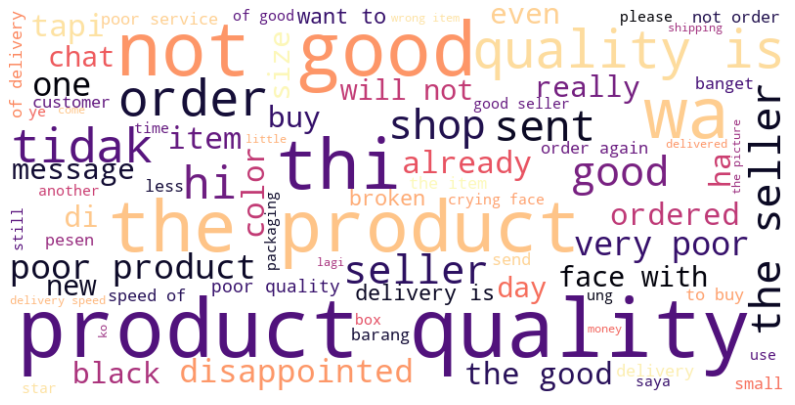

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator

rating_1_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma', max_words=80).generate(rating_1_text)

plt.imshow(rating_1_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Rating 3

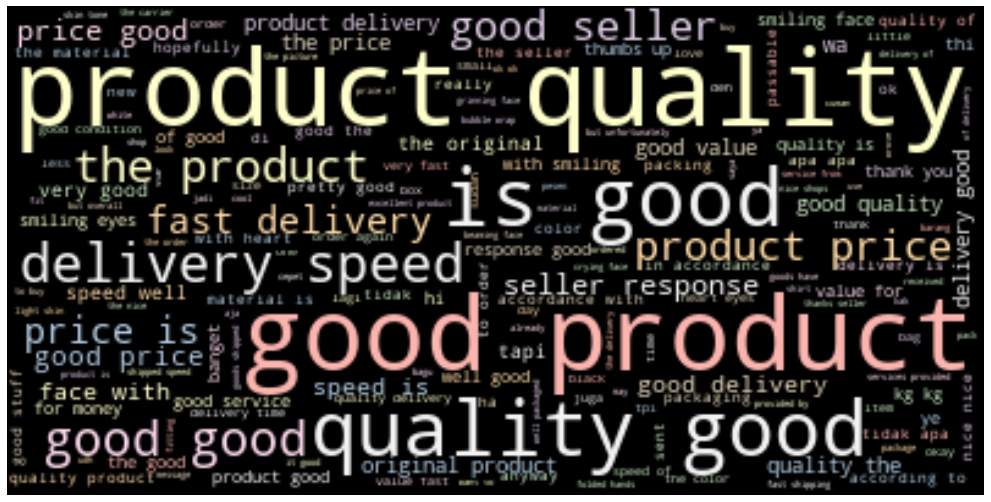

In [ ]:
from PIL import Image

# Load image
# mask = np.array(Image.open('/kaggle/input/masks/masks-wordclouds/upvote.png'))

rating_3_wordcloud = WordCloud(background_color='black', max_font_size=300, colormap='Pastel1').generate(rating_3_text)

plt.imshow(rating_3_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

### Rating 5

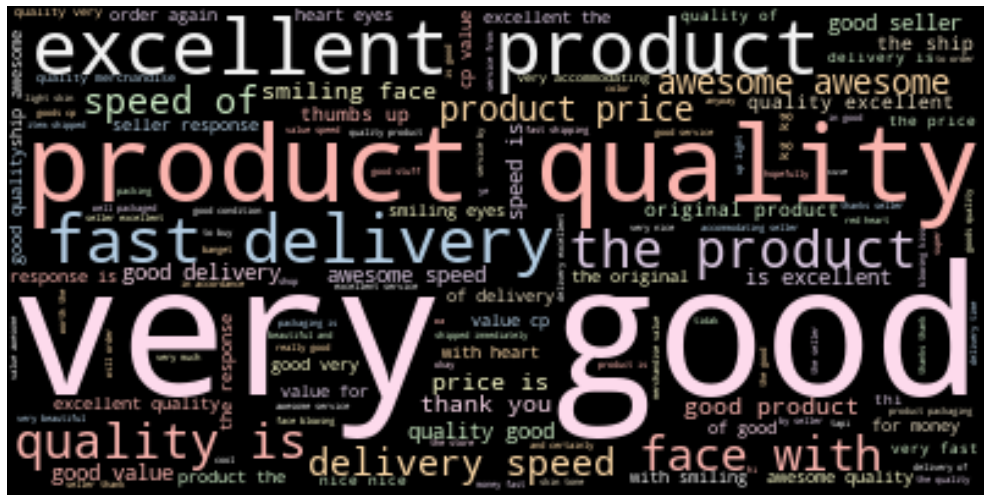

In [ ]:
# Load image
# mask = np.array(Image.open('/kaggle/input/masks/masks-wordclouds/star.png'))

rating_5_wordcloud = WordCloud(background_color='black', max_font_size=300, colormap='Pastel1').generate(rating_5_text)

plt.imshow(rating_5_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

## Rating Comparison

* Class imbalanced
* Rating 1 + 2 (negative) - only 19% from the entire dataset
* Rating 4 + 5 (positive) - 56.77% from the entire dataset

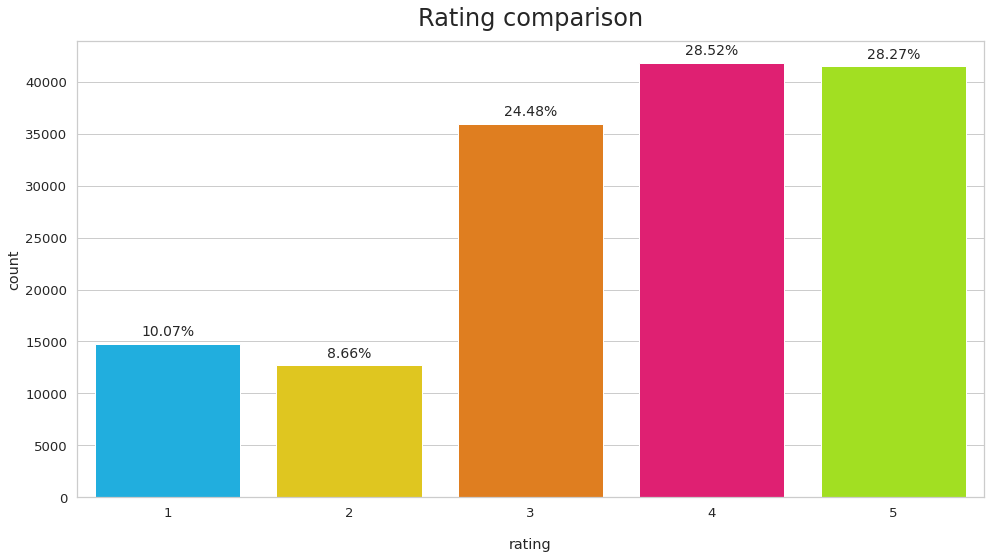

In [ ]:
ax = sns.countplot(train_df['rating'])

for val in ax.patches:
    pct = '{:.2f}%'.format(100 * val.get_height() / train_df.shape[0])
    xpos = val.get_x() + val.get_width() / 2.
    ypos = val.get_height()
    ax.annotate(pct, (xpos, ypos), ha='center', va='center', fontsize=14, xytext=(0, 12), textcoords='offset points')
    
plt.title('Rating comparison', fontsize=24, pad=15)
plt.xlabel('rating', labelpad=18)
plt.tight_layout()
plt.show()

# Usually more data we have, better performance we can achieve

Deep Learning models typically have millions of parameters, thus require large amounts of data for training in order for over-fit avoidance and better model generalization. However, collecting a large annotated data samples is time-consuming and expensive. One technique aiming to address such a data hungry problem is data augmentation.

Proper data augmentation is useful to boost up your model performance. Augmentation is very popular in computer vision area. Image can be augmented easily by flipping, rotation, random cropping etc. It is proved that augmentation is one of the anchor to success of computer vision model.

In Natural Language Processing field, it is hard to augmenting text due to high complexity of language. Not every word we can replace it by others such as a, an, the. Also, not every word has synonym. Even changing a word, the context will be totally difference.

There are several techniques to do **text augmentation**:
* Synonym Replacement: Randomly replace n words in the sentences with their synonyms
* Random Insertion: Insert random synonyms of words in a sentence, this is done n times
* Random Deletion: Random removal for each word in the sentence with a probability p
* Contextualized Word Embeddings
* Text Generation (GPT-2 or XLNet)

> For detail you can [check here](https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28). In this notebook we'll use [nlpaug](https://pypi.org/project/nlpaug/) library. If you're interested, you also can check their tutorial example.

In [ ]:
!pip install nlpaug -q

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw

## Try Contextualized Word Embeddings

Actually this is my first time using text augmentation, so i choosed **Contextualized Word Embeddings** as an experiment. We can try Synonym Replacement, Random Deletion etc

Remember we have class imbalance problem. We also can add rating 1 & 2 training dataset using this technique. Maybe we can get a better score.

> It will took approximate 3 hours if you run code below. If you don't want to wait, you can use [my augmented data here](https://www.kaggle.com/indralin/text-augmented)

In [ ]:
# %%time

# review_augmented = []

# # action = "insert" or 'substitute (default)'
# aug = naw.ContextualWordEmbsAug(model_path='bert-base-multilingual-uncased', action='insert')
# # aug = naw.ContextualWordEmbsAug(model_path='bert-base-multilingual-uncased', action='substitute', aug_p=0.5) # higher aug_p = substitute more words

# for review in train_df['review']:
#     augmented_text = aug.augment(review)
#     review_augmented.append(augmented_text)

In [ ]:
# train_aug = pd.DataFrame({'review': review_augmented,
#                           'rating': train_df['rating']})

# # filter rows that have words less than 10
# train_aug[train_aug['review'].str.len() >= 10].to_csv('review_aug_insert.csv', index=False)

In [ ]:
train_aug =  pd.read_csv('text-augmented/review_aug_insert.csv')

print('train aug shape:', train_aug.shape)

train aug shape: (146612, 2)


In [ ]:
print('Original:')
print(train_df['review'].loc[12])

print('\nAugmented:')
print(train_aug['review'].loc[12])

print('\nOriginal:')
print(train_df['review'].loc[9])

print('\nAugmented:')
print(train_aug['review'].loc[9])

Original:
very different each photograph tidak realpict

Augmented:
very 150 different image each photograph tidak realpict

Original:
pictures and names of elise 7154 but the brand bg balqis other code x necessarily the same things verry disappointed

Augmented:
pictures and names remain of elise 7154 , but the brand bg balqis other . code x necessarily the same same as things by ver -ry disappointed


In [ ]:
train_df = pd.concat([train_df, train_aug], axis=0, ignore_index=True)

## Modeling

In [ ]:
!pip install transformers -q

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
# from kaggle_datasets import KaggleDatasets

import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.2.0


In [ ]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
             texts, 
             return_attention_mask=False, 
             return_token_type_ids=False,
             pad_to_max_length=True,
             max_length=maxlen)
    
    return np.array(enc_di['input_ids'])

In [ ]:
def build_model(transformer, max_len=512):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(5, activation='softmax')(cls_token) # 5 ratings to predict
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 4
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
# MODEL = 'jplu/tf-xlm-roberta-large' # bert-base-multilingual-uncased
MODEL = 'huggingface/prunebert-base-uncased-6-finepruned-w-distil-mnli' # 

In [ ]:
# since tf.keras reads your data take 0 as the reference, our category should start from 0 not 1
rating_mapper_encode = {1: 0,
                        2: 1,
                        3: 2,
                        4: 3,
                        5: 4}

# convert back to original rating after prediction later(dont forget!!)
rating_mapper_decode = {0: 1,
                        1: 2,
                        2: 3,
                        3: 4,
                        4: 5}

train_df_mapped = train_df.copy()
train_df_mapped['rating'] = train_df['rating'].map(rating_mapper_encode)

In [ ]:
lv1_mapper = { 0: 0,
               1: 0,
                2: 1,
                3: 1,
                4: 1
                }
lv2_mapper = { 0: 0,
               1: 1,
                2: 0,
                3: 1,
                4: 2
                }

train_df_mapped['rating_lv1'] = train_df_mapped['rating'].map(lv1_mapper)
train_df_mapped['rating_lv2'] = train_df_mapped['rating'].map(lv2_mapper)
train_df_mapped.tail()

,review,rating,rating_lv1,rating_lv2
293349,extremely excellent consumer product quality delivery speed is a very good very good seller respin,4,1,2
293350,thanks for gan,4,1,2
293351,awesome aw -eso [MASK]me market quality merc producthandise value of cp very nice thumbs up,4,1,2
293352,nice pack -ing boxes made effective . price fast shipping,4,1,2
293353,excellent product in quality excellent product price is very competitive good delivery at speed,4,1,2


In [ ]:
from tensorflow.keras.utils import to_categorical

# convert to one-hot-encoding-labels
train_labels = to_categorical(train_df_mapped['rating'], num_classes=5)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df_mapped['review'],
                                                  train_labels,
                                                  stratify=train_labels,
                                                  test_size=0.1,
                                                  random_state=2020)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((264018,), (29336,), (264018, 5), (29336, 5))

In [ ]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
MAX_LEN = 192

X_train = regular_encode(X_train.values, tokenizer, maxlen=MAX_LEN)
X_val = regular_encode(X_val.values, tokenizer, maxlen=MAX_LEN)
X_test = regular_encode(test_df['review'].values, tokenizer, maxlen=MAX_LEN)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(X_test)
    .batch(BATCH_SIZE)
)

In [ ]:
%%time

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Some weights of the model checkpoint at huggingface/prunebert-base-uncased-6-finepruned-w-distil-mnli were not used when initializing TFBertModel: ['classifier', 'dropout_37']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at huggingface/prunebert-base-uncased-6-finepruned-w-distil-mnli.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.
Model: "model"
_________________________________________________________

In [ ]:
%%time
n_steps = X_train.shape[0] // BATCH_SIZE

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_acc:.4f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_acc')
    ]
)

Epoch 1/4
   83/16501 [..............................] - ETA: 2:47:42 - loss: 1.5344 - accuracy: 0.2703

KeyboardInterrupt: 

In [ ]:
plt.style.use('fivethirtyeight')

# Get training and test loss histories
training_loss = train_history.history['loss']
test_loss = train_history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

NameError: name 'train_history' is not defined

In [0]:
pred = model.predict(test_dataset, verbose=1)

In [0]:
# don't forget to save for ensemble
np.save('prunebert-base-uncased-6-finepruned-w-distil-mnli', pred)

In [0]:
pred_sentiment = np.argmax(pred, axis=1)

print(pred_sentiment)

In [0]:
submission = pd.DataFrame({'review_id': test_df['review_id'],
                           'rating': pred_sentiment})

## Last, don't forget to convert back our rating values to 1 - 5

In [0]:
submission['rating'] = submission['rating'].map(rating_mapper_decode)

submission.to_csv('submission.csv', index=False)

# References

* [Emoticon and Emoji in Text Mining](https://medium.com/towards-artificial-intelligence/emoticon-and-emoji-in-text-mining-7392c49f596a)
* [Data Augmentation in NLP](https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28)